### PYTORCH WORKFLOW

Cover to topic:
1. Prepare the data
2. Build model
3. Fitting the model to data (training)
4. Making prediction and evaluating a model (Inference)
5. Putting it all together


In [1]:
import torch
from torch import nn #contain all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

## 1. DATA (PREPARING AND LOADING)

data can be almost anything... in machine learning.

*Excel spreadsheet
* Images of any kind
* Videos
* Audio like song or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data and convert into a numerical representation(tensors)
2. Build a model to learn patterns in that numerical representation

To showcase this, I will create a *known* data using the **linear regression formula**

We'll use a linear regression formula to make a straight line with known parameters.



In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02


X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len (y)

(50, 50)

In [4]:
# Create a train/ test split

train_split = int(0.8 * len(X)) #80% of data
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

"Visualize! Visualize! Visualize!"

In [27]:
def plot_prediction(train_data = X_train,
                    train_labels= y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):

# Plots training data, test data and compares predictions.
  plt.figure(figsize=(8, 5))

  # Plot training data in blue (train x and y)
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Purely for test data x and y
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
      # Plot prediction if it exist
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 12})

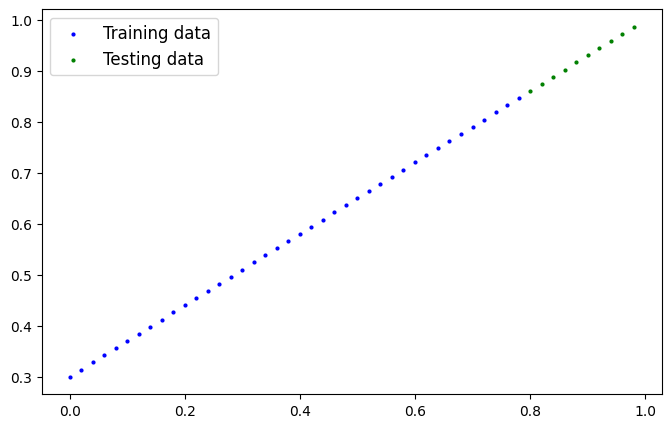

In [28]:
plot_prediction()

## Building model

This will be my first PyTorch model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent(or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithm:
1. Gradient descent - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropogation - https://www.youtube.com/watch?v=Ilg3gGewQ5U


In [125]:
# Create linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everthing in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    # Use nn.Linear()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias #Linear regression formula




### PYTORCH MODEL BUILDSING ESSENTIALS

* torch.nn - contains all the buildings for computational graphs (Neural network are consider as computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
*torch.nn.Module - The base class for all neural network module, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient decent
*def forward() - all nn.Module subclasses require you to overwrite forward(), this method where you define the computation


## Checking the contents of our PyTorch model

Now that we created a model, lets see what's inside...
we can check the model's parameters or whats inside our model using .parameters().

In [126]:
# Create a random seed
torch.manual_seed(42)

# Create a intance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [127]:
## list our parameters
model_0.state_dict(), #dictionary


(OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]),)

### Making prediction using `torch.inference_mode()`

To check out our model's prediction power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the `forward()`

In [128]:
# Make prediction with model

with torch.inference_mode(): #Diable the gradient decent and other stuff to make computation of data faster
  y_preds = model_0(X_test)

y_preds  #Because our weight and bias is randomize at the model our model wasn't able to predict the value of y_test

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [129]:
#Our target value is the value of y_test
y_test # compare to the y_preds their is still configuration we need to make our model accurate

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

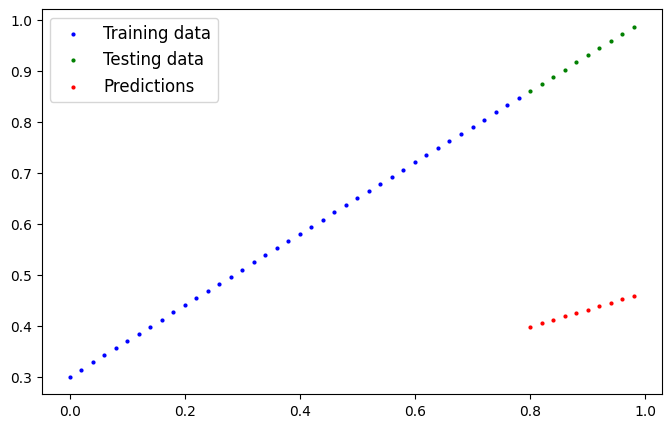

In [130]:
plot_prediction(predictions=y_preds) #

## 3. TRAINING OUR MODEL

The goal of this training is for our model *unknown* parameter move to some known parameters.

One way to measure how poor or how wrong our models predication are, is to use PyTorch loss function.

* **NOTE:** Loss funtion can also be called cost function or criterion.

**Loss Function** is to measure how wrong your model's prediction to the ideal outputs.

**Optimizer:** Takes into account the loss function of a model and adjust the model's parameter( e.g. weight & bias ) to improve the loss function
  * Two parameters of optimizer:
      
      * params - the model parameter you'd like to optimize, for example `params=model_0.parameters()`

      * lr(learning rate) - A hyoperparameter that defines how big/small the optimizer changes the parameters with each step(a small lr result in small changes, a large lr result in large changes)


For this, we need:
* A Training loop
* A Testing loop



In [131]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [132]:
# Check out our models parameters (A parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [133]:
# Setup a loss function

loss_fn = nn.L1Loss()


# Setup an optimizer  (stochastic gradient descent)

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) #Learning rate = possible the most important hyperparameter you can set
#



### BUILDING A TRAINING AND TESTING LOOP IN PYTORCH

Steps:
0. Loop through the data
1. Forward pass (This involves moving through our model's `forward()` method) - also called forward propogation
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropogation**)
5. Optimzer step - use the optimizer to adjust our model's parameter to try and improve the loss (**gradient descent**)

In [134]:
torch.manual_seed(42)
# epochs
epochs = 100
# an epoch is one loop through the data...

### TRAINING

# Step 0: Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() #Train mode in Py Torch set all parameters that require gradients that require gradients

  # Step 1: Forward pass
  y_preds = model_0(X_train)

  # Step 2: Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # Step 3: Optimizer zero grad
  optimizer.zero_grad()

  # Step 4: Loss backward
  loss.backward()

  # Step 5: Optimizer step
  optimizer.step()



  ### TESTING
  model_0.eval() # turn off gradient tracking

  with torch.inference_mode():
    #Step 1. Do the forward pass
    test_preds = model_0(X_test)

    #Step 2. Calculate the loss
    test_loss = loss_fn(test_preds, y_test)


  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    # Print out model state_dic()

  print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
OrderedDict([('weights', tensor([0.3835])), ('bias', tenso

In [135]:
test_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [136]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

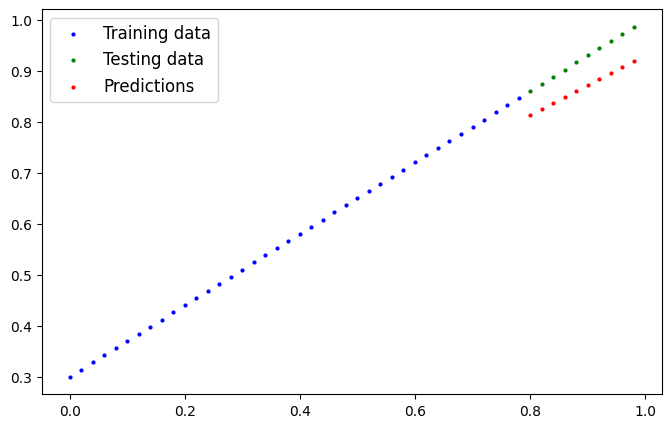

In [137]:
plot_prediction(predictions=y_preds_new)